In [1]:
import networkx as nx
from node2vec import Node2Vec
from src import *
import numpy as np
from sklearn import metrics

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'karateclub', 'graph_tool', 'infomap', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [2]:
N = 100
gamma = 2.5
kmin = 3
kmax = np.sqrt(N)
prob = 1.0
sign = -1

pfi = 0.4


D = generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)

In [3]:
G, H = duplex_network(D, 1, 2)

R_G, R_H, agg = partial_information(G, H, pfi)

10


In [4]:
G_emb = Node2Vec(R_G, dimensions=128, walk_length=30, num_walks=200, workers=4).fit(window=10, min_count=1, batch_words=4)
H_emb = Node2Vec(R_H, dimensions=128, walk_length=30, num_walks=200, workers=4).fit(window=10, min_count=1, batch_words=4)

G_ = G_emb.wv.vectors
H_ = H_emb.wv.vectors

print(G_.shape, H_.shape)

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 79.09it/s]


(100, 128) (100, 128)


In [5]:
cls = []
gt = []
for src, tgt in agg:
    v_G_src = G_[src, :]
    v_G_tgt = G_[tgt, :]
    v_H_src = H_[src, :]
    v_H_tgt = H_[tgt, :]

    d_G = np.linalg.norm(v_G_src - v_G_tgt)
    d_H = np.linalg.norm(v_H_src - v_H_tgt)

    if d_G < d_H:
        cls.append(0)
    elif d_H > d_G:
        cls.append(1)
    else:
        cls.append(np.random.randint(0, 2))

    if (src, tgt) in G.edges():
        gt.append(0)
    else:
        gt.append(1)

acc = metrics.accuracy_score(gt, cls)

In [6]:
print(acc)

0.5411255411255411


In [7]:
def embbedding_exp(N, gamma, kmin, kmax, prob, sign, pfis):
    D = generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)
    G, H = duplex_network(D, 1, 2)

    accs = []
    for pfi in pfis:
        R_G, R_H, agg = partial_information(G, H, pfi)
        G_emb = Node2Vec(R_G, dimensions=128, walk_length=30, num_walks=200, workers=4).fit(window=10, min_count=1, batch_words=4)
        H_emb = Node2Vec(R_H, dimensions=128, walk_length=30, num_walks=200, workers=4).fit(window=10, min_count=1, batch_words=4)

        G_ = G_emb.wv.vectors
        H_ = H_emb.wv.vectors

        cls = []
        gt = []
        for src, tgt in agg:
            v_G_src = G_[src, :]
            v_G_tgt = G_[tgt, :]
            v_H_src = H_[src, :]
            v_H_tgt = H_[tgt, :]

            d_G = np.linalg.norm(v_G_src - v_G_tgt)
            d_H = np.linalg.norm(v_H_src - v_H_tgt)

            if d_G < d_H:
                cls.append(0)
            elif d_H > d_G:
                cls.append(1)
            else:
                cls.append(np.random.randint(0, 2))

            if (src, tgt) in G.edges():
                gt.append(0)
            else:
                gt.append(1)

        acc = metrics.accuracy_score(gt, cls)
        accs.append(acc)

    return pfis, accs

In [8]:
N = 100
gamma = 2.5
kmin = 3
kmax = np.sqrt(N)
prob = 1.0
sign = -1

pfis = [0.0, 0.2, 0.4, 0.6, 0.8]
pfis, accs = embbedding_exp(N, gamma, kmin, kmax, prob, sign, pfis)

12


Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 99.88it/s] 


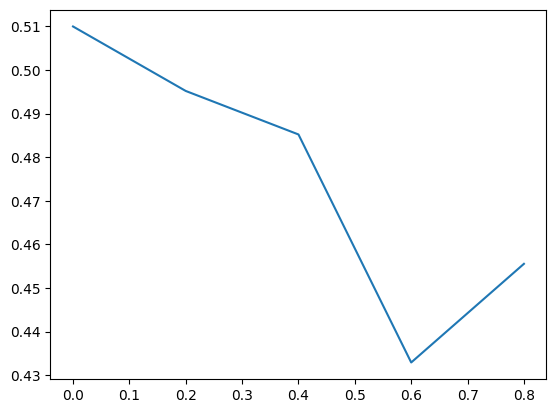

In [9]:
plt.figure()
plt.plot(pfis, accs)